In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from datetime import datetime, timedelta

from control.modules.pvt import PvtControl, PvtParameters
from input_output.alarms import BaseAlarms
from input_output.base import Stamped, StampedDf
from input_output.definitions.control import Valve
from input_output.definitions.simulation import (
    Boundary,
    HeatSource,
    TemperatureBoundary,
    ValvePosition,
)

from input_output.modules.pvt import (
    PvtControlValues,
    PvtSensorValues,
    PvtSimulationInputs,
    PvtSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import pvt_path
import polars as pl

start_time = datetime.fromtimestamp(0)
minutes_idle = 2
minutes_recovery = 10
duration = timedelta(minutes=minutes_idle + minutes_recovery)
time_index = pl.datetime_range(
    start_time, start_time + duration - timedelta(minutes=1), interval="1m", time_unit="us", eager=True
)


pvt_main_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": minutes_idle * [0.0] + minutes_recovery * [16000.0] })
)

pvt_owners_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": minutes_idle * [0.0] + minutes_recovery * [8000.0]})
)



simulation_inputs = PvtSimulationInputs(
    pvt_main_fwd=HeatSource(heat_flow=pvt_main_heat),
    pvt_main_aft=HeatSource(heat_flow=pvt_main_heat),
    pvt_owners=HeatSource(heat_flow=pvt_owners_heat),
    pvt_pump_failure_switch_main_fwd=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_main_aft=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_owners=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_module_supply=TemperatureBoundary(temperature=Stamped.stamp(65)),
    pvt_seawater_supply=Boundary(temperature=Stamped.stamp(32), flow=Stamped.stamp(10)),
)

control = PvtControl(PvtParameters())

pvt_model = SimulatorModel(
    fmu_path=pvt_path,
    sensor_values_cls=PvtSensorValues,
    control_values_cls=PvtControlValues,
    simulation_outputs_cls=PvtSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=BaseAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)
with pvt_model.executor() as executor:
    simulation = Simulator(pvt_model, executor)

    control.to_idle()

    result = await simulation.run(minutes_idle*60)

    control.to_recovery()

    result2 = await simulation.run((minutes_recovery-1)*60)

    result = result.vstack(result2)

[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 121.158, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 121.346, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 240.07, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 241.026, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 308.39, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 327.289, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 338.432, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 377.147, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 412.457, mxstep steps taken before reaching tout.
[WA

/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_13864/2786651975.py:84: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  result = result.vstack(result2)


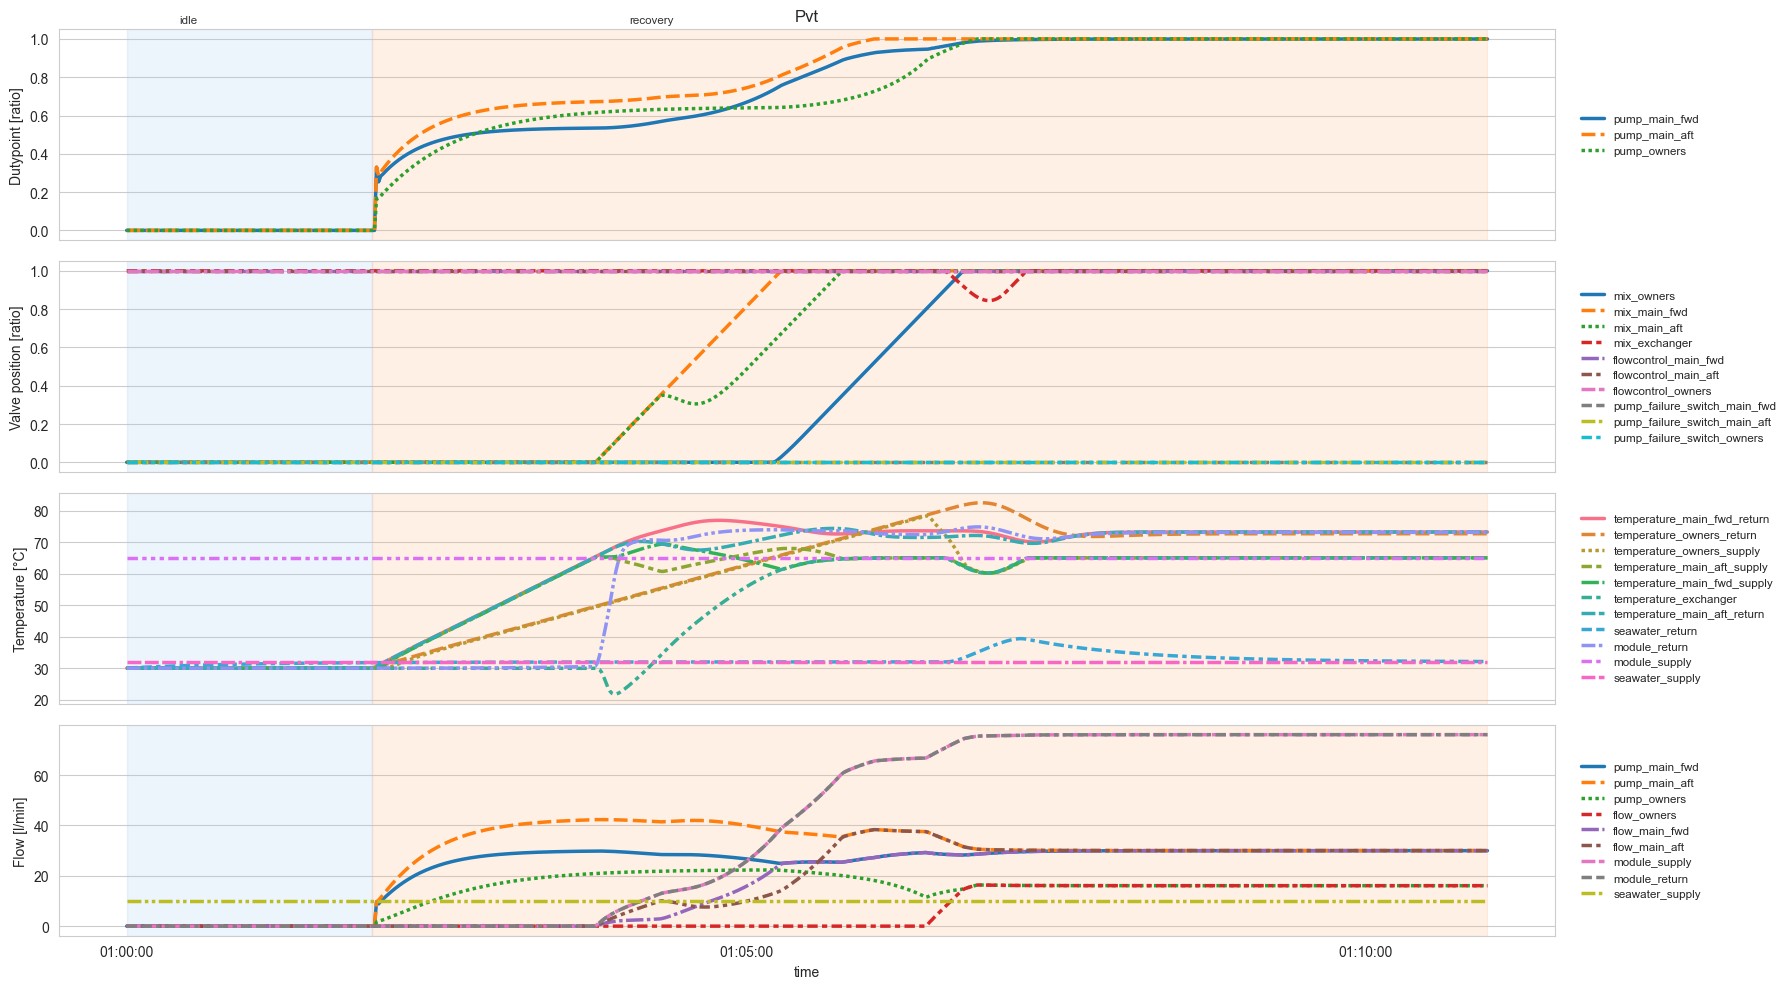

In [11]:
from analysis.analysis_utils import plot_result

plot_result(result, 'plots/pvt.png');